The intent of this algorithm is to model the dynamic between geographic and institutional factors that contribute to federal grant award amounts in order to produce a fair and accurate recommendation for the grant award amount for the prospective student. The only useful dimensions for determining how much grant award amount are the location of the school, the institution type, and the percentage of the tuition the grant covers for the student, all other factors have the potential to introduce biases into the model and are not relevant for producing a performant model. 

The features of the model will reflect factors about the educational institution, and the target is the percentage amount of the tuition was covered by the federal grant.

#### Training data:
- [Sources of Grant Aid for Full-Time Undergraduates by Sector, 2011-12 - Pell Grant data](https://trends.collegeboard.org/content/sources-grant-aid-full-time-undergraduates-sector-2011-12)
- [Federal Student Aid: Title IV Program Volume Reports - grants per institution](https://studentaid.ed.gov/sa/about/data-center/student/title-iv)
- [College Scorecard - tuition data](https://catalog.data.gov/dataset/college-scorecard) (Accessing this data requires an API key for data.gov, which is granted here: [https://api.data.gov/signup/](https://api.data.gov/signup/))

In [12]:
import glob
import json
import os
import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn_transformers.preprocessing import FeatureSelector
from sklearn_transformers.preprocessing import MultiColumnLabelEncoder
from sklearn_transformers.regression import RegressorWithNoise
import regression_report

### Download data:

To model the scenario outlined above, the data required is an anonymized individual-level federal grant award dataset (where each row represents one person’s school, the school’s tuition, and the percent of the tuition the grant amount covered). Unfortunately, the government does readily provide such a dataset, however, these features can be assembled with other existing datasets: the Pell Grant data for full-time undergraduate students which provides the maximum amount awarded per student, the Federal Student Aid's Title IV program which outlines the total amount of grants per educational institution, and lastly the educational institution's tuition provided by College Scorecard.

The first dataset (Sources of Grant Aid for Full-Time Undergraduates by Sector, 2011-12), will provide the maximum Pell Grant amounts awarded per year. The maximum amount award will later be used to determine the percent awarded.

In [10]:
pell_grat_filename = 'pell_grant.xlsx'
pell_grant_url = 'http://research.collegeboard.org/sites/default/files/sa-2018-figure-21a.xlsx'

response = requests.get(pell_grant_url)
with open(pell_grat_filename, 'wb') as out_file:
    out_file.write(response.content)

def parse_pell_grant_data_start_year(x):
    s = int(x[:2])
    if s >= 77:
        return str(1900 + s)
    else:
        return str(2000 + s)

pell_grant_data = pd.read_excel(
    pell_grat_filename,
    header=1,
    usecols=[i for i in range(3)],
    nrows=41
)
pell_grant_data['start_year'] = pell_grant_data['Academic Year'].apply(parse_pell_grant_data_start_year)
pell_grant_data.columns = [col.strip().lower().replace(' ', '_') for col in pell_grant_data.columns]
print(pell_grant_data.shape)
pell_grant_data.sample(5)

(41, 4)


,academic_year,maximum_pell_grant,average_pell_grant_per_recipient,start_year
24,01-02,5170,3170,2001
34,11-12,6010,3850,2011
12,89-90,4530,2830,1989
15,92-93,4180,2690,1992
14,91-92,4310,2750,1991


The second dataset is the Federal Student Aid Title IV Volume reports that detail grand disbursements per institution per year (from https://studentaid.ed.gov/sa/about/data-center/student/title-iv). The Q4 data has the complete data for the given year.

In [33]:
base_url = 'https://studentaid.gov/sites/default/files/'
student_loans_data_urls = []

for year in range(6, 18):
    this_year = f'{year}'.zfill(2)
    next_year = f'{year + 1}'.zfill(2)
    if 13 <= year:
        url = f'{base_url}fsawg/datacenter/library/'
    else:
        url = base_url        
    student_loans_data_urls.append(f'{url}Q4{this_year}{next_year}AY.xls')  

for url in student_loans_data_urls:
    print(url)
    filename = os.path.basename(url)
    response = requests.get(url)
    with open(filename, 'wb') as out_file:
        out_file.write(response.content)

https://studentaid.gov/sites/default/files/Q40607AY.xls
https://studentaid.gov/sites/default/files/Q40708AY.xls
https://studentaid.gov/sites/default/files/Q40809AY.xls
https://studentaid.gov/sites/default/files/Q40910AY.xls
https://studentaid.gov/sites/default/files/Q41011AY.xls
https://studentaid.gov/sites/default/files/Q41112AY.xls
https://studentaid.gov/sites/default/files/Q41213AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41314AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41415AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41516AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41617AY.xls
https://studentaid.gov/sites/default/files/fsawg/datacenter/library/Q41718AY.xls


In [43]:
grant_dfs = []

for fp in sorted(glob.glob('Q4*AY.xls')):
    print(fp)
    sheetname = [sheetname for sheetname in pd.read_excel(fp, sheet_name=None).keys() if ' YTD' in sheetname or sheetname == 'Award Year Summary'][0]
    header_col = [i for i, r in enumerate(pd.read_excel(fp, sheet_name=sheetname).iloc[:10, 0]) if r == 'OPE ID'][0]
    temp_df = pd.read_excel(
        fp,
        sheet_name=sheetname,
        header=[header_col, header_col+1],
        dtype='object',
    )
    col_index = [True if col.startswith('Unnamed') or col == 'FEDERAL PELL GRANT PROGRAM' else False for col in temp_df.columns.get_level_values(0)]
    temp_df = temp_df.iloc[:, col_index]
    temp_df.columns = temp_df.columns.droplevel()
    temp_df.columns = [col.strip().lower() for col in temp_df.columns]
    temp_df = temp_df.rename(columns={
        'sum of recipients': 'pell grant ytd recipients',
        'ytd recipients': 'pell grant ytd recipients',
        'sum of disbursements':  'pell grant ytd disbursements',
        'ytd disbursements': 'pell grant ytd disbursements',
    })
    label = fp.split('/')[-1][:-4]
    temp_df['spreadsheet'] = label
    temp_df['academic_year'] = f'20{label[2:4]}'
    temp_df['ope id'] = temp_df['ope id'].apply(lambda x: str(x).zfill(8))
    grant_dfs.append(temp_df)


grants_df = pd.concat(grant_dfs)
print(grants_df.shape)
grants_df.sample(5)

Q40607AY.xls
Q40708AY.xls
Q40809AY.xls
Q40910AY.xls
Q41011AY.xls
Q41112AY.xls
Q41213AY.xls
Q41314AY.xls
Q41415AY.xls
Q41516AY.xls
Q41617AY.xls
Q41718AY.xls
(65518, 9)


,ope id,school,state,zip code,school type,pell grant ytd recipients,pell grant ytd disbursements,spreadsheet,academic_year
5294,04232400,VANTAGE COLLEGE - SAN ANTONIO,TX,782304823,Proprietary,163,639774,Q41516AY,2015
2153,00218100,MASSACHUSETTS MARITIME ACADEMY,MA,25323400,Public,211,834973,Q41011AY,2010
2793,01043400,RENTON TECHNICAL COLLEGE,WA,980564195,Public,1159,3.6932e+06,Q41314AY,2013
5549,00382300,WEST LIBERTY UNIVERSITY,WV,260740295,Public,1094,4.33732e+06,Q40910AY,2009
5307,03822400,MAPLE SPRINGS BAPTIST BIBLE COLLEGE & SEMINARY,MD,207435711,PRIVATE-NONPROFIT,6,12819.5,Q40607AY,2006


Lastly, information about how much tutition is for each institution is needed. This data is provided by [College Scorecard on data.gov](https://catalog.data.gov/dataset/college-scorecard). However, it requires an API key ([sign up here](https://api.data.gov/signup/)) to programmatically download the data and the API is rate limited, so this step can take a while and is designed to run multiple times until the full data is collected.

Need to know the tuition for each of the institutions in the `grant_amounts` dataset, so each individual excel sheet needs to be loaded into a dataframe, so we can access that field

In [44]:
url = 'https://api.data.gov/ed/collegescorecard/v1/schools'
API_KEY = #'<YOUR DATA.GOV API KEY>'
params = {
    'api_key': API_KEY,
    '_per_page': 100
}
ids = set(grants_df['ope id'].values) - {fp.split('/')[-1][:8] for fp in glob.glob('data/*.json')}

for ope_id in ids:
    params = {'ope8_id': ope_id}
    local_filename = f'{ope_id}_tuition_data.json'
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        with open(local_filename, 'wb') as out_file:
            out_file.write(response.content)
    if response.status_code != 200:
        print(f'error: {response.url}, {response.status_code}, {json.dumps(response.text)}')
    if int(response.headers['X-RateLimit-Remaining']) == 0:
        print('stopping, over rate limit')
        break

    print('X-RateLimit-Remaining:', int(data.response.headers['X-RateLimit-Remaining']))

#### Combine the datasets:
The grants data are in semi-regularly formatted excel spreadsheets, the code below extracts the relevant data from the sheets.

In [52]:
filepaths = glob.glob('*_tuition_data.json')
school_data = []
for fp in filepaths:
    with open(fp, 'r') as infile:
        d = json.load(infile)
    if len(d['results']) == 0:
        continue
    for k, v in d['results'][0].items():
        try:
            row = {
                'ope8_id': fp.split('/')[-1][:8],
                'year': int(k),
                'out_of_state_tuition': v['cost']['tuition']['out_of_state'],
                'in_state_tuition': v['cost']['tuition']['in_state'],
            }
            school_data.append(row)
        except:
            pass

tuition_df = pd.DataFrame(school_data, columns=['ope8_id', 'year', 'out_of_state_tuition', 'in_state_tuition'])
tuition_df = tuition_df.sort_values(by=['ope8_id', 'year']).reset_index(drop=True)
print(tuition_df.shape)
print(len(tuition_df.ope8_id.unique()))
tuition_df.sample(5)

(91819, 4)
4993


,ope8_id,year,out_of_state_tuition,in_state_tuition
2451,00117200,2000,23234.0,23234.0
13906,00204000,1996,NaN,NaN
71419,02331300,2003,NaN,NaN
38494,00393700,2015,5780.0,5780.0
39416,00407200,2003,13995.0,13995.0


In [53]:
grants_df = grants_df.merge(
    pell_grant_data[['start_year', 'maximum_pell_grant']],
    left_on=['academic_year'],
    right_on=['start_year'],
)
grants_df['academic_year'] = grants_df['academic_year'].astype('int64')

_df = grants_df.merge(
    tuition_df, 
    how='left',
    left_on=['ope id', 'academic_year'],
    right_on=['ope8_id', 'year'],
)

print(_df.shape)
_df.sample(5)

(65518, 15)


,ope id,school,state,zip code,school type,pell grant ytd recipients,pell grant ytd disbursements,spreadsheet,academic_year,start_year,maximum_pell_grant,ope8_id,year,out_of_state_tuition,in_state_tuition
33842,00116300,CHAFFEY COMMUNITY COLLEGE,CA,917379400,PUBLIC,8178,24161737,Q41213AY,2012,2012,5930,00116300,2012.0,6169.0,1153.0
48108,02606300,PAUL MITCHELL THE SCHOOL WICHITA,KS,672261321,Proprietary,136,515309,Q41415AY,2014,2014,5890,02606300,2014.0,NaN,NaN
28830,00280600,ROCHESTER INSTITUTE OF TECHNOLOGY,NY,146235608,Private-Nonprofit,4378,17252884,Q41112AY,2011,2011,6010,00280600,2011.0,32037.0,32037.0
5909,00161400,KAUAI COMMUNITY COLLEGE,HI,967669591,PUBLIC,173,397713,Q40708AY,2007,2007,5060,00161400,2007.0,6184.0,1552.0
28862,00285300,SUNY MARITIME COLLEGE,NY,104654198,Public,449,1799213,Q41112AY,2011,2011,6010,00285300,2011.0,15507.0,6457.0


### Preprocess:

In order to transform the raw data into a state prepared for modeling, some preprocessing must occur. There are three predominant transformations: `calculate_average_amount()`, `convert_region()`, and determining the `grant_coverage_percent` based on in-state or out-of-state students, as well as the cleanup and standarization of some columns.

In [59]:
_df = _df.rename(columns={'school type': 'school_type'})
_df = _df.drop(columns=['ope8_id', 'year'])
_df = _df[~_df['pell grant ytd recipients'].isin(['-'])]

def convert_to_numeric(x):
    try:
        return pd.to_numeric(x)
    except:
        return np.nan

_df['pell grant ytd disbursements'] = _df['pell grant ytd disbursements'].apply(convert_to_numeric)
_df['pell grant ytd recipients'] = _df['pell grant ytd recipients'].apply(convert_to_numeric)
_df['school_type'] = _df['school_type'].str.lower()

The first transformation, `calculate_average_amount()`, calculates teh average amount of grant disbursements by dividing the total grant amount per institution per year by the total number of grant recipients per institution per year.

In [55]:
def calculate_average_amount(row):
    if row['pell grant ytd recipients'] > 0:
        return row['pell grant ytd disbursements'] / row['pell grant ytd recipients']
    else:
        return 0.0

_df['avg_amount'] = _df.apply(calculate_average_amount, axis=1)

The second transformation, `convert_region()`, determines the educational institution's geographical region by the state it's located in. This reduces feature complexity and allows for broader geographic patterns to be a identified within the model.

In [56]:
state_regions = {
    'northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NY', 'NJ' , 'PA'],
    'midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'south': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX', 'PR', 'AS', 'VI'],
    'west': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA', 'GU', 'FM', 'MH', 'MP', 'PW'],
}

def convert_region(state_abbr):
    for region, states in state_regions.items():
        if state_abbr in states:
            return region
    return


_df['region'] = _df['state'].apply(convert_region)
_df = _df.dropna(subset=['region'])

Lastly, the final transformation required in the preprocessing step is to determine the `grant_coverage_percent` by spliting the institutional grant support by in-state and out-of-state students.

In [57]:
df_1 = _df.copy()[_df['maximum_pell_grant'] >= _df['out_of_state_tuition']]
df_1['in_state'] = False
df_1['grant_coverage_percent'] = df_1['avg_amount'] / df_1['out_of_state_tuition']

df_2 = _df.copy()[_df['maximum_pell_grant'] >= _df['in_state_tuition']]
df_2['in_state'] = True
df_2['grant_coverage_percent'] = df_2['avg_amount'] / df_2['in_state_tuition']

df = pd.concat([
    df_1[['school_type', 'region', 'in_state', 'grant_coverage_percent']],
    df_2[['school_type', 'region', 'in_state', 'grant_coverage_percent']]
])

df = df[df['grant_coverage_percent'] >= 1]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['grant_coverage_percent'])

print(df.shape)
df.sample(5)

(7008, 4)


,school_type,region,in_state,grant_coverage_percent
35645,public,midwest,True,1.374659
16906,public,west,True,5.160827
17561,public,south,True,1.686983
8541,public,south,False,1.049253
7216,public,south,True,1.838589


## Model:

In [60]:
feature_columns = ['school_type', 'region', 'in_state']
target_column = 'grant_coverage_percent'

x = df.copy()[feature_columns]
y = df.copy()[target_column]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

print(len(x_train), len(x_test))

5606 1402


In [65]:
model = Pipeline([
    ('feature_selector', FeatureSelector(columns=feature_columns)),
    ('feature_column_encoder', MultiColumnLabelEncoder(columns=feature_columns)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ('estimator', RegressorWithNoise(
        RandomForestRegressor(
            n_estimators=1000,
            max_features='sqrt',
            max_depth=30,
            random_state=1337,
        )
    ))
])
model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('feature_selector',
                 FeatureSelector(columns=['school_type', 'region',
                                          'in_state'])),
                ('feature_column_encoder',
                 <sklearn_transformers.preprocessing.MultiColumnLabelEncoder object at 0x12cf47c50>),
                ('encoder',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', n_v...
                 RegressorWithNoise(regressor=RandomForestRegressor(bootstrap=True,
                                                                    criterion='mse',
                                                                    max_depth=30,
                                                                    max_features='sqrt',
                                                                    max_leaf_nodes=None,
    

Accuracy:                     66.56835
MSE                           0.667359
RMSE                          0.816921
RMSLE                         0.246439
MAE                           0.570403
R2                            0.287289
Adj R2                        0.285722
Median                        1.526953
Avg absolute error (degrees)  0.570403

----------------------------------------
Feature Importances:
region=west                   0.535032
region=south                  0.235529
region=midwest                0.071175
in_state=False                0.048998
in_state=True                 0.048195
school_type=public            0.025314
school_type=private-nonprofit 0.022218
region=northeast              0.013398
school_type=proprietary       0.000142


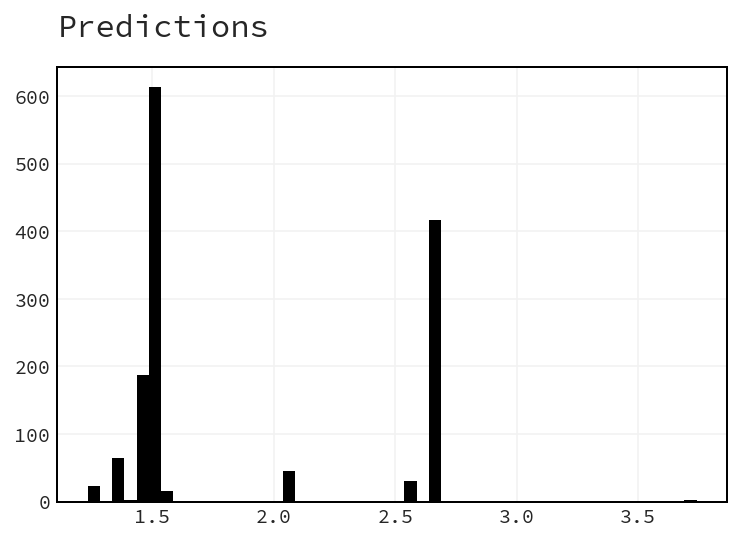

array([1.57357623, 1.53039386, 1.45738286, 1.53785178, 1.47611995])

In [66]:
regression_report.evaluate(model, x_test, y_test, encoder_step_label='feature_column_encoder')
display(model.predict(x_test.sample(5)))